In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder

%matplotlib inline


In [3]:
# Reading in the data
df = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/train.csv')


In [4]:
# Taking a look at the first 5 rows of data
df.head()


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
3,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
4,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0


In [5]:
# Getting the shape of the dataset
df.shape


(28984, 8)

In [6]:
df.dtypes.value_counts().sort_values(ascending=False)


object     6
float64    1
int64      1
Name: count, dtype: int64

In [7]:
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)


image_name                       28984
patient_id                        2056
sex                                  2
anatom_site_general_challenge        6
diagnosis                            9
benign_malignant                     2
dtype: int64

In [8]:
df['patient_id'].value_counts()


patient_id
IP_4382720    104
IP_0656529    102
IP_4938382    101
IP_7279968     98
IP_4479736     97
             ... 
IP_9460738      1
IP_7650895      1
IP_6981218      1
IP_5068447      1
IP_8007315      1
Name: count, Length: 2056, dtype: int64

In [9]:
df['patient_id'].value_counts().mean()


14.09727626459144

In [10]:
df['target'].value_counts()


target
0    28471
1      513
Name: count, dtype: int64

In [11]:
def plot_analysis(col_name, df, plot_kind='bar'):
    """
    Function to plot two subplots containing Joe's and non-Joe's counts of data points for a given feature.
    :param col_name: Column name of the feature to be analysed
    :param df: DataFrame containing the source of data
    :plot_kind: Line plot or Bar Plot
    :return True: Boolean indicating that the analysis has been plotted
    """
    
    df_benign = df[df['target']==0]
    df_malignant = df[df['target']!=0]
    fig, axs = plt.subplots(2,figsize=(26,8))
    fig.suptitle('Difference between ' + col_name + ' of patients in benign and malignant cases ')
    axs[0].set_title('Benign')
    axs[0].set_ylabel('Number of cases', fontsize=12)
    axs[1].set_title('Malignant')
    axs[1].set_ylabel('Number of cases', fontsize=12)
    axs[1].set_xlabel(col_name, fontsize=12)
    if plot_kind == 'line':
        axs[0].plot(df_benign[col_name].value_counts().index, df_benign[col_name].value_counts().values)
        axs[1].plot(df_malignant[col_name].value_counts().index, df_malignant[col_name].value_counts().values)
    elif plot_kind == 'bar':
        axs[0].bar(df_benign[col_name].value_counts().index, df_benign[col_name].value_counts().values)
        axs[1].bar(df_malignant[col_name].value_counts().index, df_malignant[col_name].value_counts().values)
    return True


True

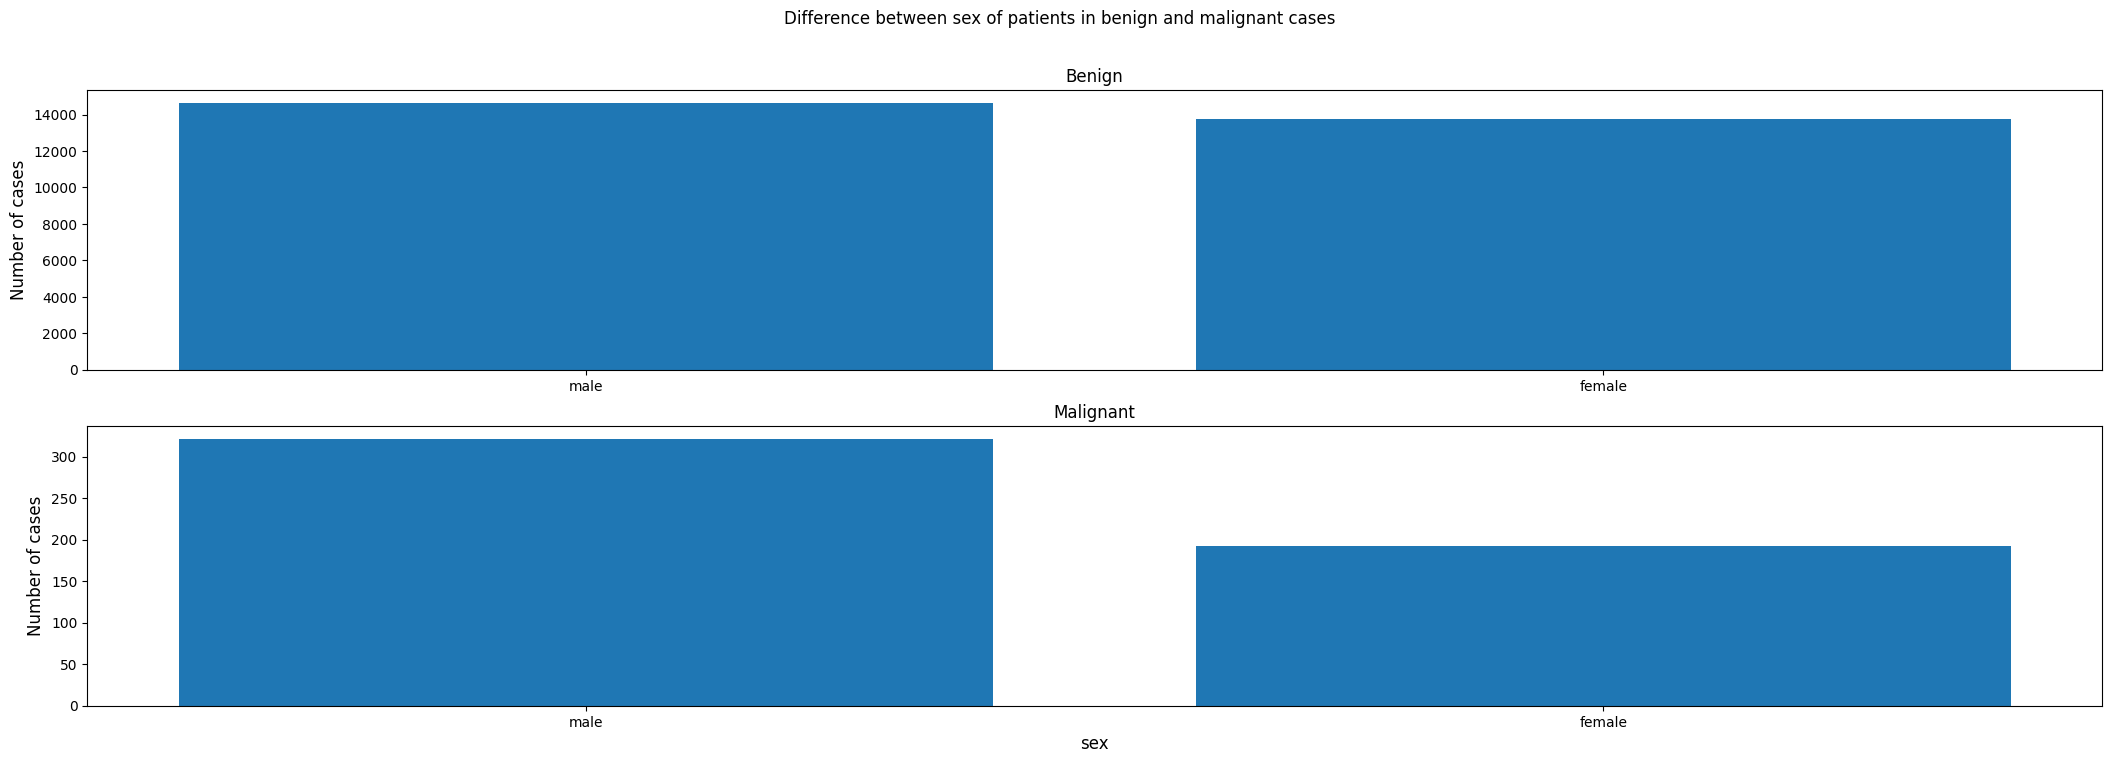

In [12]:
plot_analysis('sex', df)


True

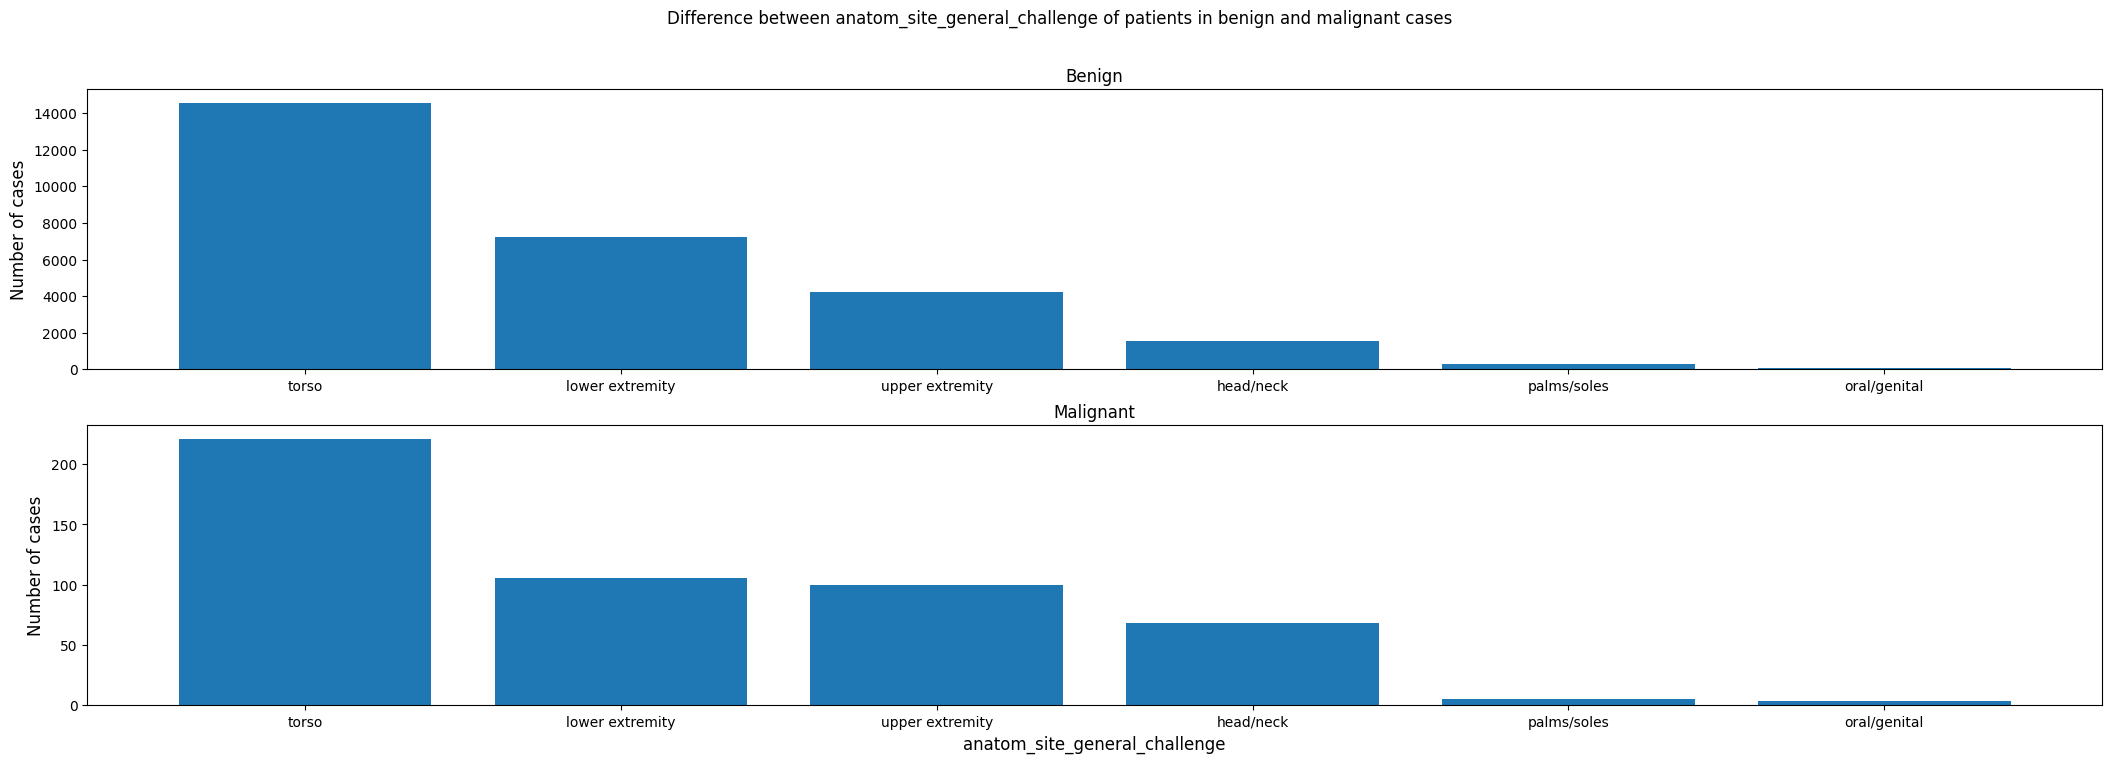

In [13]:
plot_analysis('anatom_site_general_challenge', df)


True

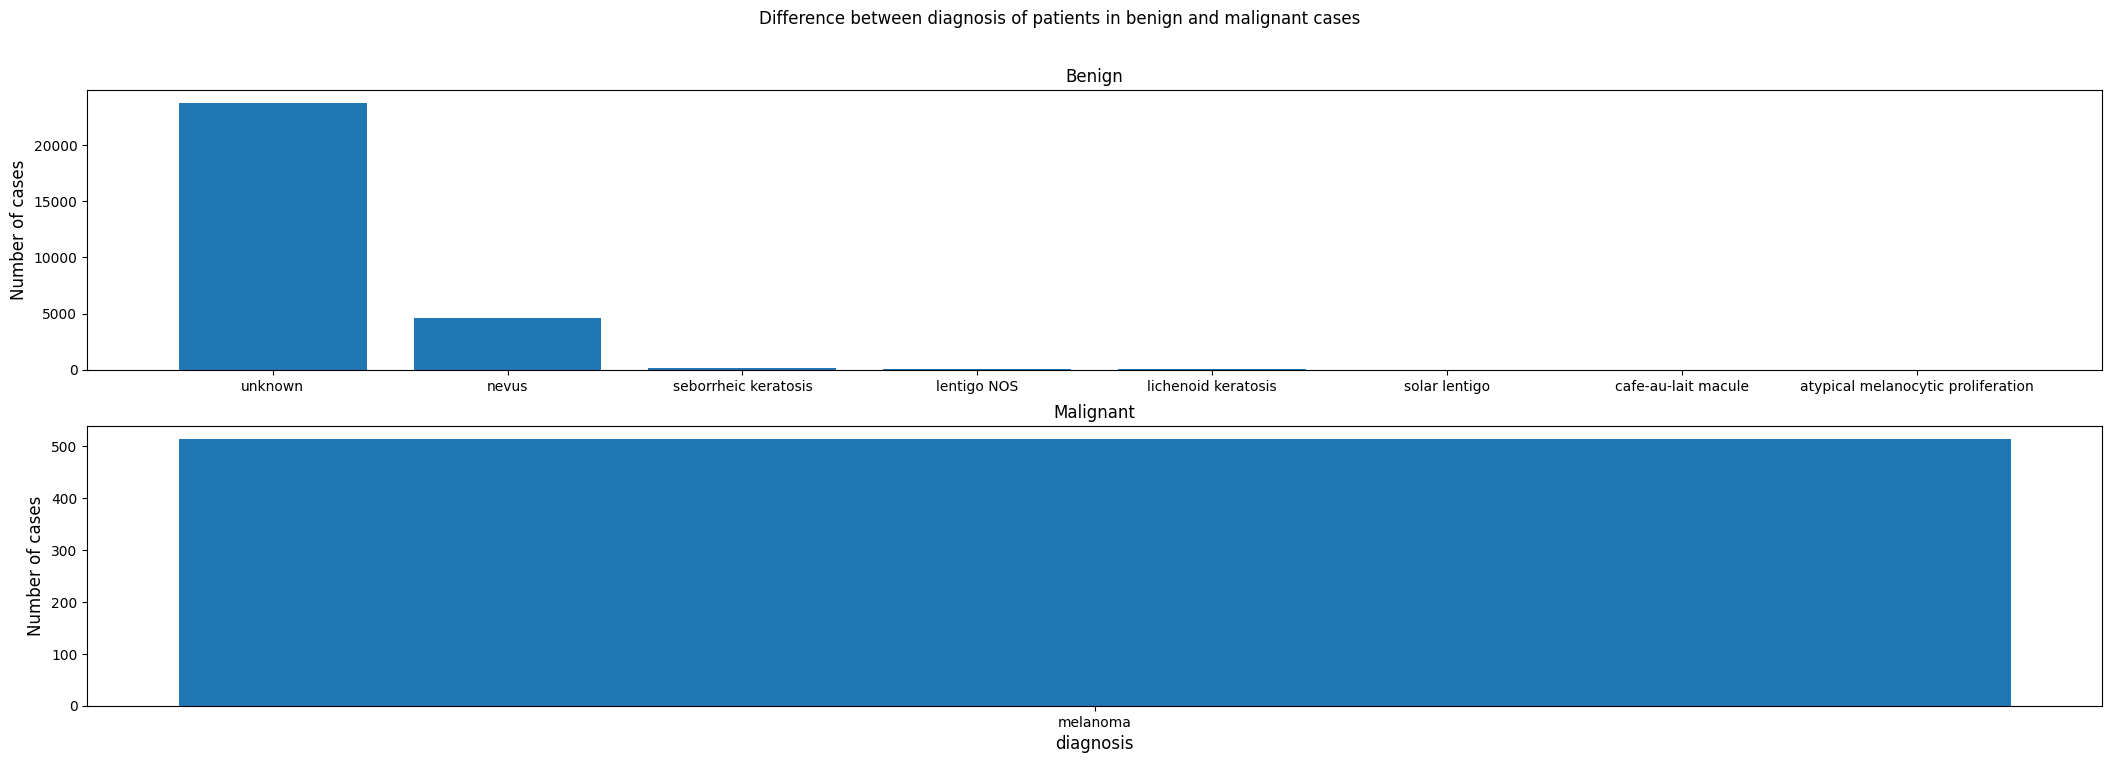

In [14]:
plot_analysis('diagnosis', df)


True

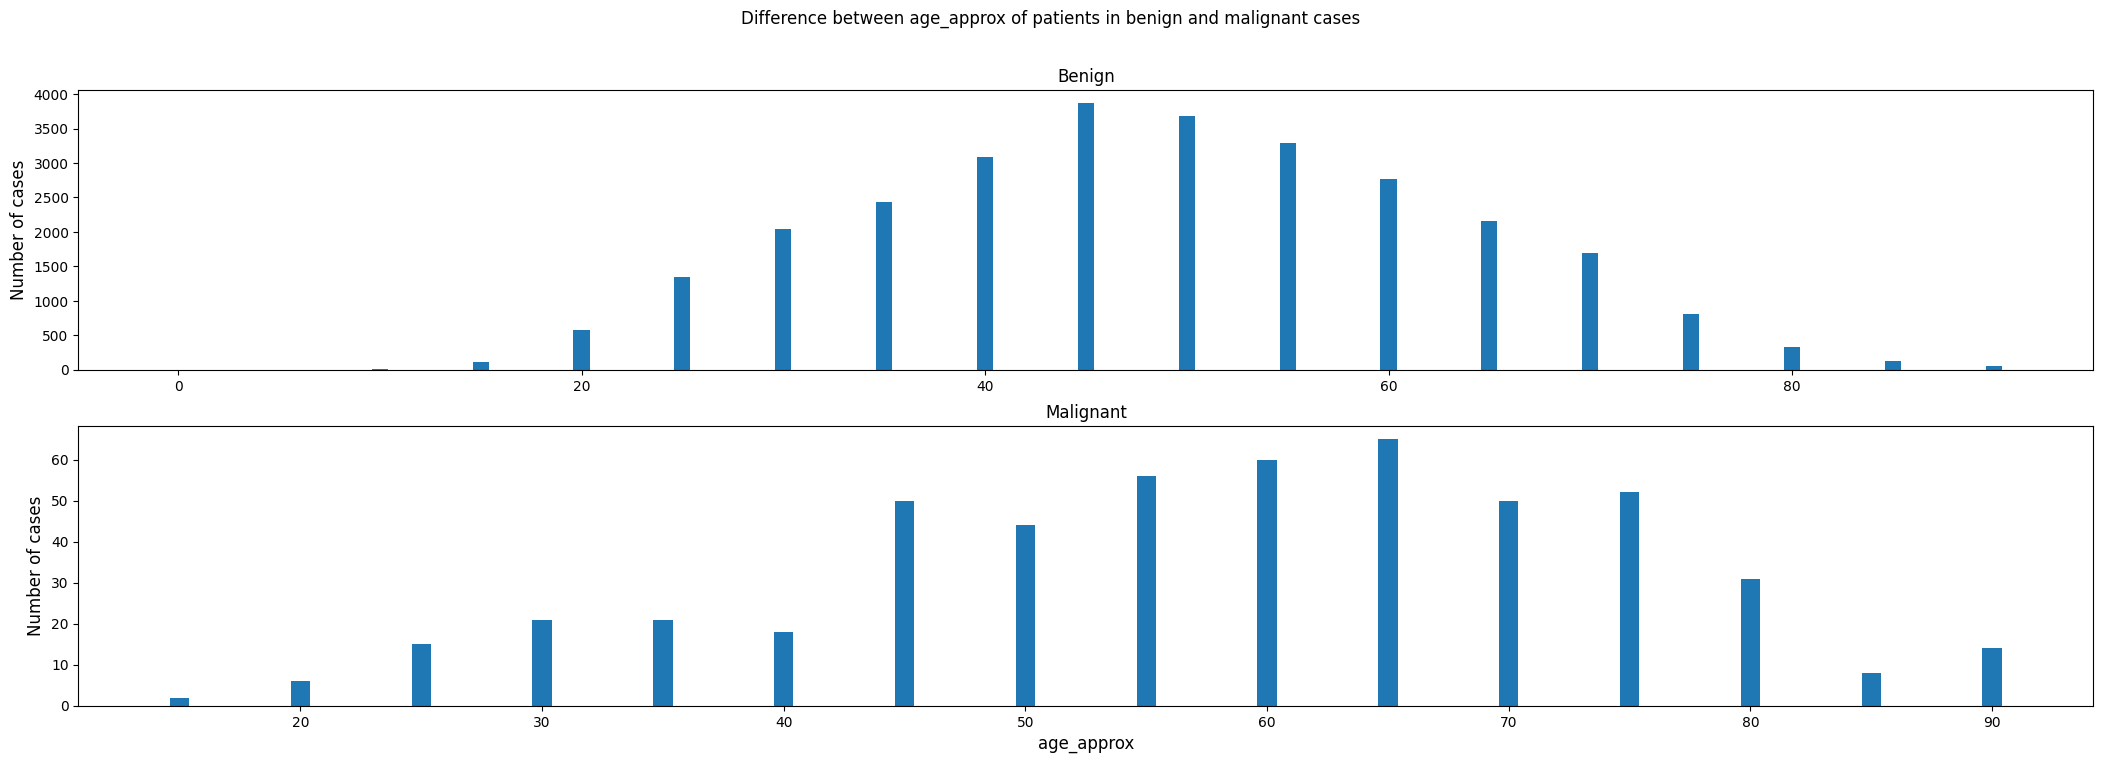

In [15]:
plot_analysis('age_approx', df)


In [16]:
df.isnull().sum()


image_name                         0
patient_id                         0
sex                               56
age_approx                        59
anatom_site_general_challenge    466
diagnosis                          0
benign_malignant                   0
target                             0
dtype: int64

In [17]:
def data_preparation(df, evaluation = False):
    # Filling in the missing values
    df['sex'] = df['sex'].fillna('male')
    df['age_approx'] = df['age_approx'].fillna(df['age_approx'].mean())
    df['anatom_site_general_challenge'] = df['anatom_site_general_challenge'].fillna('torso')

    # Label encoding sex
    labelencoder = LabelEncoder()
    df['sex'] = labelencoder.fit_transform(df['sex'])

    df = pd.get_dummies(df, columns=['anatom_site_general_challenge'])

    if evaluation:
        X_return = df.drop(['image_name', 'patient_id'], axis = 1)
        return X_return
    else:
        X_return = df.drop(['image_name', 'patient_id', 'benign_malignant','target','diagnosis'], axis = 1)
        return X_return, df['target']


In [18]:
X, y = data_preparation(df)


In [19]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

# Gradient Boosting Model
clf = LGBMClassifier(
            objective='binary',
            n_estimators=100000,
            num_leaves=10,
            learning_rate=0.1,
            max_depth=16,
            subsample_for_bin= 200000,
            subsample=1,
            subsample_freq= 200,
            silent=-1,
            verbose=-1,
            min_split_gain=0.0001,
            min_child_samples=800,
            )

# Training the model
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='auc', verbose=200, early_stopping_rounds=1000)


TypeError: LGBMClassifier.fit() got an unexpected keyword argument 'verbose'

In [20]:
test_df  = pd.read_csv('../input/siim-isic-melanoma-classification/test.csv')
test_df.head()


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052212,IP_2842074,female,50.0,lower extremity
1,ISIC_0076545,IP_9802602,male,55.0,upper extremity
2,ISIC_0085172,IP_1705144,female,50.0,lower extremity
3,ISIC_0086709,IP_4109313,male,30.0,torso
4,ISIC_0109568,IP_0825081,male,80.0,lower extremity


In [21]:
# Preprocessing test data
eval_X = data_preparation(test_df, evaluation = True)


In [22]:
# Getting the prediction probability
prediction_list = clf.predict_proba(eval_X)
final_pred_list = [a[1] for a in prediction_list]


NotFittedError: Estimator not fitted, call fit before exploiting the model.

In [23]:
# Appending to the test dataframe
test_df['target'] = final_pred_list


NameError: name 'final_pred_list' is not defined

In [24]:
test_df[['image_name','target']].to_csv('submission.csv',index=False)


KeyError: "['target'] not in index"